# Calculations on nested structures

In [1]:
import numpy
MHT_pt = numpy.empty(55432, dtype=numpy.float32)
MHT_phi = numpy.empty(55432, dtype=numpy.float32)

def calculateMHT(events, MHT_pt, MHT_phi):
    i = 0
    for event in events:
        mht_px = 0.0
        mht_py = 0.0
        mht_pz = 0.0
        for electron in event.Electron:
            mht_px += electron.pt * cosh(electron.eta) * sin(electron.phi)
            mht_py += electron.pt * cosh(electron.eta) * cos(electron.phi)
            mht_pz += electron.pt * sinh(electron.eta)
        for muon in event.Muon:
            mht_px += muon.pt * cosh(muon.eta) * sin(muon.phi)
            mht_py += muon.pt * cosh(muon.eta) * cos(muon.phi)
            mht_pz += muon.pt * sinh(muon.eta)
        for jet in event.Jet:
            if jet.pt > 150:
                mht_px += jet.pt * cosh(jet.eta) * sin(jet.phi)
                mht_py += jet.pt * cosh(jet.eta) * cos(jet.phi)
                mht_pz += jet.pt * sinh(jet.eta)

        MHT_pt[i] = sqrt(mht_px**2 + mht_py**2)
        MHT_phi[i] = -atan2(MHT_pt[i], mht_pz)
        i += 1

In [2]:
import time
import math
import uproot
tree = uproot.open("~/storage/data/nano-TTLHE-2017-09-04-uncompressed.root")["Events"]

startTime = time.time()
tree.arrowed.run(calculateMHT, (MHT_pt, MHT_phi), env=math.__dict__)
endTime = time.time()

print("Time for one run: {0} seconds".format(endTime - startTime))

Time for one run: 2.46075606346 seconds


In [ ]:
import pandas
pandas.DataFrame({"MHT_pt": MHT_pt, "MHT_phi": MHT_phi})

In [ ]:
import time
from PhysicsTools.NanoAODTools.postprocessing.framework.postprocessor import PostProcessor
from PhysicsTools.NanoAODTools.postprocessing.examples.mhtProducer import *

p = PostProcessor(".", ["/home/pivarski/storage/data/nano-TTLHE-2017-09-04-uncompressed.root"], "Jet_pt > 150", "keep_and_drop.txt", [mht()], compression="ZLIB:0", friend=True)

startTime = time.time()
p.run()
endTime = time.time()

print("Time for one run: {0} seconds".format(endTime - startTime))

Just as `tree` has a `.pandas` connector, it has a `.arrowed` connector to present itself as an Arrow dataset, which is used to compile the function.

This includes a ROOT branch ⟷ nested schema mapping.

In [ ]:
print(tree.arrowed.schema().format())

Using this mapping, we walk through the structure of the code and replace object references with array lookups.

In [ ]:
tree.arrowed.run(calculateMHT, (MHT_pt, MHT_phi), env=math.__dict__, debug=True)

This is a formal process, like a compilation pass. To be rigorous, we need to do type inference through the code tree.

Finally, the transformed code, which consists of nothing but numbers and arrays of numbers, is passed to Numba, a numerical Python compiler.

<table>
<tr style="background: white"><td><center><img src="http://numba.pydata.org/_static/numba_blue_icon_rgb.png" width="200"></center></td></tr>
<tr><td style="font-size: 18pt">Numba <a href="http://numba.pydata.org/">numba.pydata.org</a></td></tr>
</table>

Even without the full compilation, the transformation by itself speeds up access considerably.

In [ ]:
startTime = time.time()
tree.arrowed.run(calculateMHT, (MHT_pt, MHT_phi), env=math.__dict__, numba=None)
endTime = time.time()

print("Time for one run: {0} seconds".format(endTime - startTime))

Compilation results in fast code, but it's hard to debug. The thing we like about Python is the ease of *exploring* data. For interacting with individual objects, use proxies:

In [ ]:
events = tree.arrowed.proxy()

In [ ]:
events

A proxy pretends to be a Python object, fetching the data you ask for on demand. Every time you look at a particle attribute, it reads one TBasket from the ROOT file or reuses a previously read one.

Compilation is for high throughput; proxies are for low latency.

Compiled functions can return proxies.

In [ ]:
def event_with_bigjet(events):
    for event in events:
        for jet in event.Jet:
            if jet.pt > 1000:
                return event

event = tree.arrowed.run(event_with_bigjet)

In [ ]:
[jet.pt for jet in event.Jet]

You *can* use existing code in these compiled functions. If the code references other Python functions, it will (someday) extend the compilation process to include those other functions. It can also call functions defined in C.

Here's the catch: C, not C++.

C functions can be loaded from `.so` files without name mangling and executed as pointers, needing only the argument signature. C++ files require more vital information from the header files.

**Solution:** use ROOT's Cling to make C functions on demand.

In [3]:
import ROOT
import ctypes

# we want a ROOT histogram
h = ROOT.TH1I("h", "", 150, 0, 150)

# make a function (to get a function pointer) that fills h
ROOT.gInterpreter.Declare("void h_Fill(double x) { h->Fill(x); }")

# turn it into an integer and pass it from C++ to Python
ROOT.gInterpreter.Declare("size_t ptr_h_Fill = reinterpret_cast<size_t>(h_Fill);")

# use Python's ctypes to interpret that integer as a callable function
h_Fill = ctypes.CFUNCTYPE(None, ctypes.c_double)(ROOT.ptr_h_Fill)

Welcome to JupyROOT 6.08/04


In [4]:
def process(events):
    for event in events:
        for jet in event.Jet:
            h_Fill(jet.pt)

tree.arrowed.run(process, env={"h_Fill": h_Fill})

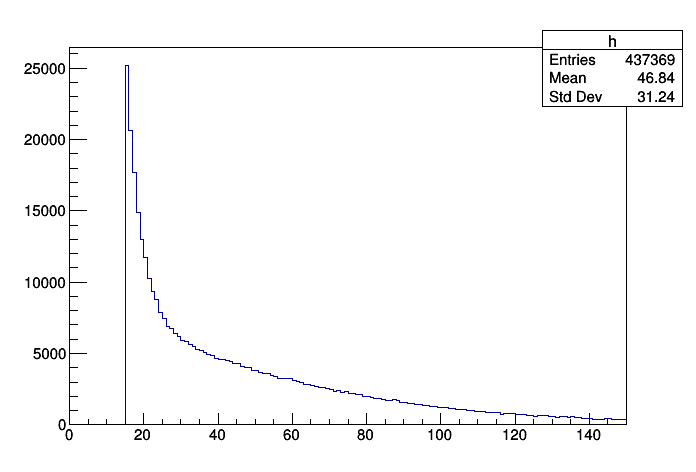

In [5]:
c = ROOT.TCanvas()
h.Draw()
c.Draw()

In [6]:
ROOT.TLorentzVector   # cause ROOT to dyload the library
ROOT.gInterpreter.Declare("""
double mass(double pt1, double eta1, double phi1, double pt2, double eta2, double phi2) {
    TLorentzVector v1, v2;
    v1.SetPtEtaPhiM(pt1, eta1, phi1, 0);
    v2.SetPtEtaPhiM(pt2, eta2, phi2, 0);
    return (v1 + v2).M();
}
size_t ptr_mass = reinterpret_cast<size_t>(mass);
""")

mass = ctypes.CFUNCTYPE(ctypes.c_double,                                    # return type
                        ctypes.c_double, ctypes.c_double, ctypes.c_double,  # parameter types
                        ctypes.c_double, ctypes.c_double, ctypes.c_double
                       )(ROOT.ptr_mass)

In [12]:
h.Reset()
tree = uproot.open("~/storage/data/SingleElectronRun2015D_16Dec2015_v1_0000_1.root")["Events"]

def calc_masses(events):
    i = 0
    for event in events:
        e1 = None
        e2 = None
        for electron in event.Electron:
            if e1 is None or electron.pt > e1.pt:
                e2 = e1
                e1 = electron
                continue
            if e2 is None or electron.pt > e2.pt:
                e2 = electron
        if e1 is not None and e2 is not None:
            h_Fill(mass(e1.pt, e1.eta, e1.phi, e2.pt, e2.eta, e2.phi))
        i += 1

tree.arrowed.run(calc_masses, env={"mass": mass, "h_Fill": h_Fill})

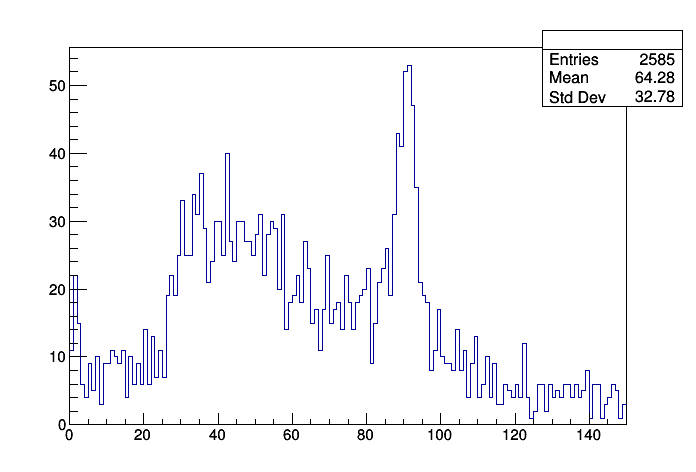

In [13]:
h.Draw()
c.Draw()

The interface I've shown is not how it will eventually look. This `run` function is 